In [ ]:
# Imports
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from collections import deque
import pygame
import random
import matplotlib.pyplot as plt
from os import truncate


/Users/sparshgupta/Documents/Battle-Of-The-Bots/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
# DQN model which takes in the state as an input and outputs predicted q values for every possible action
class DQN(torch.nn.Module):
    def __init__(self, state_space, action_space):
        super().__init__()
        # Add your architecture parameters here
        # You can use nn.Functional
        # Remember that the input is of size batch_size x state_space
        # and the output is of size batch_size x action_space (ulta ho sakta hai dekh lo)
        # TODO: Add code here
        self.state_space = state_space
        self.action_space = action_space

        # Define a simple MLP for Q-value prediction
        self.q_network = nn.Sequential(
            nn.Linear(state_space, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, action_space)
        )

    def forward(self, input):
        # TODO: Complete based on your implementation
        return self.q_network(input)


In [4]:
# While training neural networks, we split the data into batches.
# To improve the training, we need to remove the "correlation" between game states
# The buffer starts storing states and once it reaches maximum capacity, it replaces
# states at random which reduces the correlation.
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


In [5]:
# TODO: Implement training logic for CartPole environment here
# Remember to use the ExperienceBuffer and a target network
# Details can be found in the book sent in the group

def train_model(model, loss_fn, optimizer, episodes=600, epsilon=1.0, gamma=0.99,
                sync_batch_freq=100, train_batch_size=64, replay_buffer_size=10000):
    
    env = gym.make("CartPole-v1")
    rewards_list = []
    losses = []

    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    np.random.seed(42)
    valid_actions = np.arange(n_actions)

    # Initialize target network
    target_model = DQN(obs_dim, n_actions).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()
    model.train()

    # Create replay memory
    Buffer = ExperienceBuffer(replay_buffer_size)
    step_count = 0

    for ep in range(episodes):
        ep_reward = 0
        done = False
        obs, _ = env.reset()
        moves = 0

        while not done:
            step_count += 1
            moves += 1

            state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                q_vals = model(state_tensor)

            if np.random.rand() < epsilon:
                action = np.random.choice(valid_actions)
            else:
                action = torch.argmax(q_vals).item()

            obs, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            ep_reward += reward

            next_state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            Buffer.push(state_tensor, action, reward, next_state_tensor, done)

            if len(Buffer) > train_batch_size:
                s_batch, a_batch, r_batch, ns_batch, d_batch = Buffer.sample(train_batch_size)
                s_batch = torch.cat(s_batch, dim=0).to(device)
                a_batch = torch.tensor(a_batch, dtype=torch.long).unsqueeze(1).to(device)
                r_batch = torch.tensor(r_batch).to(device)
                ns_batch = torch.cat(ns_batch, dim=0).to(device)
                d_batch = torch.tensor(d_batch, dtype=torch.float32).to(device)


                with torch.no_grad():
                    next_q = target_model(ns_batch)
                    max_next_q = torch.max(next_q, dim=1)[0]
                    target_values = r_batch + gamma * (1 - d_batch) * max_next_q

                predicted_q = model(s_batch)
                q_selected = predicted_q.gather(1, a_batch).squeeze(1)

                loss = loss_fn(q_selected, target_values)
                losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Update target network periodically
            if step_count % sync_batch_freq == 0:
                target_model.load_state_dict(model.state_dict())
                target_model.eval()

        # Decay epsilon
        if epsilon > 0.1:
            epsilon *= 0.995

        rewards_list.append(ep_reward)

        if ep % 50 == 0:
            avg_reward = sum(rewards_list[-50:]) / 50
            print(f"Episode {ep} - Avg Reward: {avg_reward:.2f}")
            if avg_reward >= 450:
                break

    env.close()
    return rewards_list, losses


In [6]:
# Initialize CartPole environment and extract dimensions
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n
env.close()

# Set up the model, loss function, and optimizer
model = DQN(state_size, num_actions).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Start training the model
rewards, losses = train_model(model, loss_fn, optimizer)


Episode 0 - Avg Reward: 0.56
Episode 50 - Avg Reward: 22.38
Episode 100 - Avg Reward: 14.88
Episode 150 - Avg Reward: 44.56
Episode 200 - Avg Reward: 78.08
Episode 250 - Avg Reward: 328.74
Episode 300 - Avg Reward: 418.46
Episode 350 - Avg Reward: 441.66
Episode 400 - Avg Reward: 495.96


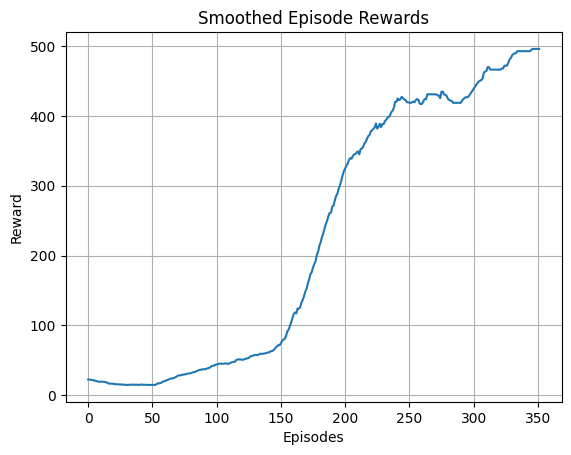

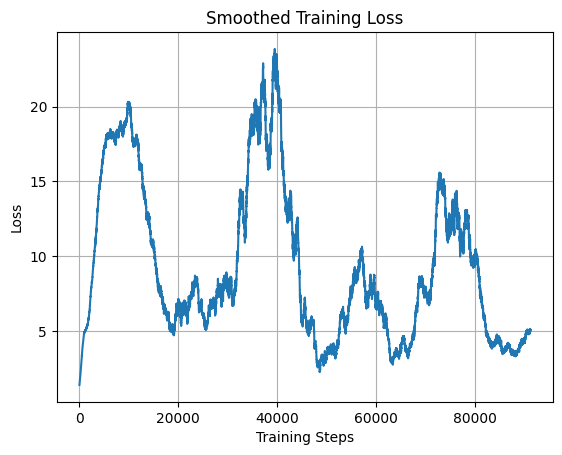

In [8]:
# Plotting smoothed reward curve using a moving average
reward_window = np.ones(50) / 50
smoothed_rewards = np.convolve(rewards, reward_window, mode='valid')
plt.plot(smoothed_rewards)
plt.title("Smoothed Episode Rewards")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

# Plotting smoothed loss curve
loss_window = np.ones(1000) / 1000
smoothed_losses = np.convolve(losses, loss_window, mode='valid')
plt.plot(smoothed_losses)
plt.title("Smoothed Training Loss")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [9]:
def evaluate_cartpole_model(model, episodes=10, render=True):
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    model.eval()
    rewards = []

    for episode in range(episodes):
        obs, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_pred = model(state)
                action = torch.argmax(q_pred, dim=1).item()

            obs, reward, done_flag, truncated_flag, _ = env.step(action)
            done = done_flag or truncated_flag
            total_reward += reward

            if render:
                env.render()

        rewards.append(total_reward)
        print(f"Episode {episode + 1} - Total Reward: {total_reward}")

    env.close()
    average = sum(rewards) / episodes
    print(f"Mean reward across {episodes} runs: {average:.2f}")


In [13]:
# TODO: Run evaluation for cartpole here
evaluate_cartpole_model(model,render=False)


Episode 1 - Total Reward: 500.0
Episode 2 - Total Reward: 500.0
Episode 3 - Total Reward: 500.0
Episode 4 - Total Reward: 500.0
Episode 5 - Total Reward: 500.0
Episode 6 - Total Reward: 500.0
Episode 7 - Total Reward: 500.0
Episode 8 - Total Reward: 500.0
Episode 9 - Total Reward: 500.0
Episode 10 - Total Reward: 500.0
Mean reward across 10 runs: 500.00


In [14]:
class SnakeGame(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, size=10, render_mode=None):
        super().__init__()
        self.size = size
        self.cell_size = 30
        self.screen_size = self.size * self.cell_size
        self.render_mode = render_mode

        self.action_space = gym.spaces.Discrete(4)  # 0: right, 1: up, 2: left, 3: down
        self.observation_space = gym.spaces.Box(0, 2, shape=(self.size, self.size), dtype=np.uint8)

        self.screen = None
        self.clock = None

        self.snake = deque()
        self.food = None
        self.direction = [1, 0]

        if self.render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.snake.clear()
        mid = self.size // 2
        self.snake.appendleft([mid, mid])
        self.direction = [1, 0]
        self._place_food()
        obs = self._get_obs()

        if self.render_mode == "human":
            self._render_init()

        return obs, {}

    def step(self, action):
        # TODO: Change reward schema to avoid the following
        # 1) 180 degree turns
        # 2) Wall collisions
        # 3) Being slow at collecting food

        if action == 0 and self.direction != [-1, 0]: self.direction = [1, 0]
        elif action == 1 and self.direction != [0, 1]: self.direction = [0, -1]
        elif action == 2 and self.direction != [1, 0]: self.direction = [-1, 0]
        elif action == 3 and self.direction != [0, -1]: self.direction = [0, 1]

        head = self.snake[0]
        new_head = [head[0] + self.direction[0], head[1] + self.direction[1]]

        done = False
        reward = 0.0

        # Wall collision check
        if new_head[0] < 0 or new_head[0] >= self.size or new_head[1] < 0 or new_head[1] >= self.size:
            done = True
            reward -= 1.0
        else:
            body = list(self.snake)
            if new_head != self.food:
                body = body[:-1]
            if new_head in body:
                done = True
                reward -= 1.0

        if not done:
            self.snake.appendleft(new_head)
            if new_head == self.food:
                self._place_food()
                reward += 10.0
            else:
                self.snake.pop()
                reward -= 0.1  # Small penalty for time-wasting

        obs = self._get_obs()

        if self.render_mode == "human":
            self.render()

        return obs, reward, done, False, {}

    def _get_obs(self):
        # TODO: Return an observation state, take inspiration from the observation_space attribute
        grid_state = np.zeros((self.size, self.size), dtype=np.uint8)

        for part in self.snake:
            x, y = part
            if 0 <= x < self.size and 0 <= y < self.size:
                grid_state[y][x] = 1  # snake body

        if self.food:
            fx, fy = self.food
            if 0 <= fx < self.size and 0 <= fy < self.size:
                grid_state[fy][fx] = 2  # food position

        return grid_state


    def _place_food(self):
        positions = set(tuple(p) for p in self.snake)
        empty = [(x, y) for x in range(self.size) for y in range(self.size) if (x, y) not in positions]
        self.food = list(random.choice(empty)) if empty else None

    def render(self):
        if self.screen is None:
            self._render_init()

        self.screen.fill((0, 0, 0))
        for x, y in self.snake:
            pygame.draw.rect(
                self.screen, (0, 255, 0),
                pygame.Rect(x * self.cell_size, y * self.cell_size, self.cell_size, self.cell_size)
            )
        if self.food:
            fx, fy = self.food
            pygame.draw.rect(
                self.screen, (255, 0, 0),
                pygame.Rect(fx * self.cell_size, fy * self.cell_size, self.cell_size, self.cell_size)
            )

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def _render_init(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.size * self.cell_size, self.size * self.cell_size))
        self.clock = pygame.time.Clock()

    def close(self):
        if self.screen:
            pygame.quit()
            self.screen = None


In [15]:
# TODO: Implement training logic for Snake Game here
import torch.optim as optim
import torch.nn.functional as F

def train_dqn_snake(env, episodes=500, gamma=0.99, epsilon_start=1.0, epsilon_min=0.1, decay=0.995,
                    learning_rate=0.001, batch_size=64, buffer_size=10000, freq=10):
    
    obs_dim = env.size * env.size
    action_dim = env.action_space.n

    policy_net = DQN(obs_dim, action_dim)
    target_net = DQN(obs_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    rewards_history = []
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    buffer = ExperienceBuffer(buffer_size)

    epsilon = epsilon_start

    for episode in range(episodes):
        obs, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(obs.flatten(), dtype=torch.float32).unsqueeze(0)

            # ε-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_vals = policy_net(state_tensor)
                action = q_vals.argmax(dim=1).item()

            next_obs, reward, done, _, _ = env.step(action)

            buffer.push(obs.flatten(), reward, action, next_obs.flatten(), done)
            obs = next_obs
            episode_reward += reward

            if len(buffer) > batch_size:
                states, rewards, actions, next_states, dones = buffer.sample(batch_size)

                states = torch.from_numpy(np.array(states)).float()
                actions = torch.from_numpy(np.array(actions)).long()
                rewards = torch.from_numpy(np.array(rewards)).float()
                next_states = torch.from_numpy(np.array(next_states)).float()
                dones = torch.from_numpy(np.array(dones)).float()

                current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    next_q = target_net(next_states).max(dim=1)[0]
                    q_target = rewards + gamma * next_q * (1 - dones)

                loss = F.mse_loss(current_q, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            rewards_history.append(episode_reward)

        if (episode + 1) % freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_min, epsilon * decay)

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}: Total Reward = {episode_reward:.2f}, Epsilon = {epsilon:.3f}")

    return policy_net, rewards_history


In [16]:
def evaluate_snake_model(model, size=20, episodes=1, render=True):
    env = SnakeGame(size=size, render_mode="human" if render else None)
    model.eval()

    all_rewards = []

    for ep in range(episodes):
        obs, _ = env.reset()
        ep_reward = 0
        terminated = False

        while not terminated:
            input_tensor = torch.tensor(obs.flatten(), dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action_values = model(input_tensor)
                chosen_action = torch.argmax(action_values, dim=1).item()

            obs, reward, terminated, _, _ = env.step(chosen_action)
            ep_reward += reward

            if render:
                env.render()

        all_rewards.append(ep_reward)
        print(f"Episode {ep + 1}: Reward = {round(ep_reward, 2)}")

    env.close()
    avg = sum(all_rewards) / episodes
    print(f"Average reward over {episodes} episodes: {round(avg, 2)}")


In [17]:
# TODO: Run evaluation for Snake Game here

# Initialize the Snake environment
env = SnakeGame(size=20, render_mode=None)  # You can change grid size if needed

# Train the agent on the environment
final_model, rewards_list = train_dqn_snake(env)

# Evaluate the trained agent's performance visually
evaluate_snake_model(final_model, size=20, episodes=1, render=True)


Episode 10: Total Reward = -5.70, Epsilon = 0.951
Episode 20: Total Reward = -10.90, Epsilon = 0.905
Episode 30: Total Reward = -2.90, Epsilon = 0.860
Episode 40: Total Reward = -2.10, Epsilon = 0.818
Episode 50: Total Reward = -3.50, Epsilon = 0.778
Episode 60: Total Reward = -6.30, Epsilon = 0.740
Episode 70: Total Reward = -3.30, Epsilon = 0.704
Episode 80: Total Reward = -2.30, Epsilon = 0.670
Episode 90: Total Reward = -2.30, Epsilon = 0.637
Episode 100: Total Reward = -4.20, Epsilon = 0.606
Episode 110: Total Reward = -5.40, Epsilon = 0.576
Episode 120: Total Reward = -5.10, Epsilon = 0.548
Episode 130: Total Reward = -2.90, Epsilon = 0.521
Episode 140: Total Reward = -2.20, Epsilon = 0.496
Episode 150: Total Reward = -2.30, Epsilon = 0.471
Episode 160: Total Reward = -5.10, Epsilon = 0.448
Episode 170: Total Reward = -4.70, Epsilon = 0.427
Episode 180: Total Reward = -2.60, Epsilon = 0.406
Episode 190: Total Reward = -4.50, Epsilon = 0.386
Episode 200: Total Reward = -4.10, Epsi

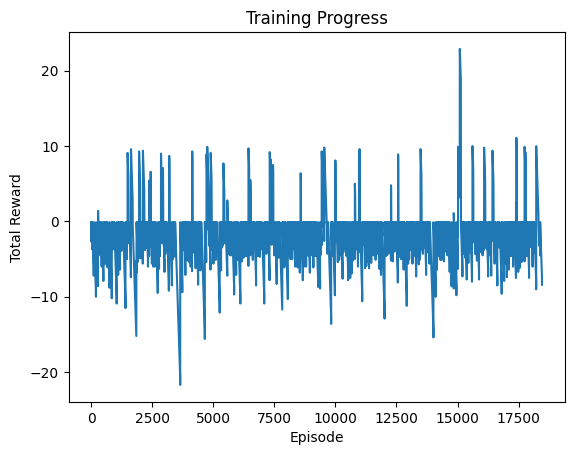

In [19]:
import matplotlib.pyplot as plt
plt.plot(rewards_list)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()


In [20]:
class ChaseEscapeEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, render_mode=None):
        super().__init__()

        self.dt = 0.1
        self.max_speed = 0.4
        self.agent_radius = 0.05
        self.target_radius = 0.05
        self.chaser_radius = 0.07
        self.chaser_speed = 0.03

        self.action_space = gym.spaces.MultiDiscrete([3, 3])  # actions in {0,1,2} map to [-1,0,1]
        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1,
            shape=(8,),
            dtype=np.float32,
        )

        self.render_mode = render_mode
        self.screen_size = 500
        self.np_random = None

        if render_mode == "human":
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
            self.clock = pygame.time.Clock()

    def sample_pos(self, far_from=None, min_dist=0.5):
        while True:
            pos = self.np_random.uniform(low=-0.8, high=0.8, size=(2,))
            if far_from is None or np.linalg.norm(pos - far_from) >= min_dist:
                return pos

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = self.sample_pos()
        self.agent_vel = np.zeros(2, dtype=np.float32)
        self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
        self.chaser_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.7)

        return self._get_obs(), {}

    def _get_obs(self):
        # Observation includes agent position, relative target/chaser positions, and agent velocity
        agent_to_target = self.target_pos - self.agent_pos
        agent_to_chaser = self.chaser_pos - self.agent_pos
        return np.concatenate([self.agent_pos, agent_to_target, agent_to_chaser, self.agent_vel])

    def _get_info(self):
        return {}

    
    def step(self, action):
        food_collected = False
        reward = 0.0
    
        # Convert action from discrete space to acceleration
        acceleration = (np.array(action) - 1) * 0.1
        self.agent_vel += acceleration
        self.agent_vel = np.clip(self.agent_vel, -self.max_speed, self.max_speed)
    
        previous_position = self.agent_pos.copy()
        self.agent_pos += self.agent_vel * self.dt
        self.agent_pos = np.clip(self.agent_pos, -1, 1)
        
        # Penalize if agent nears borders (especially both edges)
        if np.abs(self.agent_pos[0]) >= 0.9 and np.abs(self.agent_pos[1]) >= 0.9:
            reward -= float((np.abs(self.agent_pos[0]) - 0.9) * 0.1)
    
        # Chaser moves toward agent
        chaser_direction = self.agent_pos - self.chaser_pos
        dist = np.linalg.norm(chaser_direction)
        if dist > 1e-5:
            self.chaser_pos += (self.chaser_speed * chaser_direction / dist)
    
        # Measure updated distances
        current_target_dist = np.linalg.norm(self.agent_pos - self.target_pos)
        current_chaser_dist = np.linalg.norm(self.agent_pos - self.chaser_pos)
        prev_target_dist = np.linalg.norm(self.target_pos - previous_position)
        prev_chaser_dist = np.linalg.norm(self.chaser_pos - previous_position)
    
        terminated = False
    
        # Encourage moving toward target if within perceptible range
        if current_target_dist <= 0.75:
            reward += float((1.0 - current_target_dist) * 0.05)
    
        # Penalize getting closer to the chaser when within danger range
        if current_chaser_dist <= 0.20 and prev_chaser_dist > current_chaser_dist:
            reward -= 0.05
    
        # Time penalty to discourage idling
        reward -= 0.002
    
        # Reward reaching the target
        if current_target_dist < (self.agent_radius + self.target_radius):
            reward += 20.0
            self.target_pos = self.sample_pos(far_from=self.agent_pos, min_dist=0.5)
            food_collected = True
    
        # Penalize being caught
        if current_chaser_dist < (self.agent_radius + self.chaser_radius):
            reward -= 5.0
            terminated = True
    
        # Output: obs, reward, terminated, trunc, info
        return self._get_obs(), reward, terminated, food_collected, False, self._get_info()
    
    
    def render(self):
        if self.render_mode != "human":
            return

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()

        self.screen.fill((255, 255, 255))

        def to_screen(p):
            x = int((p[0] + 1) / 2 * self.screen_size)
            y = int((1 - (p[1] + 1) / 2) * self.screen_size)
            return x, y

        pygame.draw.circle(self.screen, (0, 255, 0), to_screen(self.target_pos), int(self.target_radius * self.screen_size))
        pygame.draw.circle(self.screen, (0, 0, 255), to_screen(self.agent_pos), int(self.agent_radius * self.screen_size))
        pygame.draw.circle(self.screen, (255, 0, 0), to_screen(self.chaser_pos), int(self.chaser_radius * self.screen_size))

        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])

    def close(self):
        if self.render_mode == "human":
            pygame.quit()


In [21]:
# TODO: Train and evaluate CatMouseEnv

def run_training_loop(model, target_model, loss_fn, optimizer, episodes=1000,
                      epsilon=1.0, gamma=0.95, sync_freq=100, batch_size=128, buffer_capacity=50000):
    
    env = ChaseEscapeEnv()
    
    # Tracking metrics globally for later plotting or analysis
    global rewards_list, number_of_moves_list, no_of_food_eaten_list
    rewards_list = []
    number_of_moves_list = []
    losses = []
    no_of_food_eaten_list = []

    np.random.seed(42)
    action_choices = np.arange(9)

    # Copy initial weights from model to target
    target_model.load_state_dict(model.state_dict())
    model.train()
    target_model.eval()

    memory = ExperienceBuffer(buffer_capacity)
    step_counter = 0

    for ep in range(episodes):
        ep_reward = 0.0
        done = False
        obs, _ = env.reset()
        steps = 0
        food_count = 0

        while not done:
            steps += 1
            step_counter += 1

            state_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                q_vals = model(state_tensor)

            if np.random.rand() < epsilon:
                action_idx = np.random.choice(action_choices)
            else:
                action_idx = torch.argmax(q_vals).item()

            # Convert flattened index to 2D action tuple
            action = (action_idx % 3, (action_idx // 3) % 3)

            next_obs, reward, done, got_food, _, _ = env.step(action)

            if got_food:
                food_count += 1

            ep_reward += reward

            next_state_tensor = torch.tensor(next_obs, dtype=torch.float32).to(device)

            memory.push(state_tensor, action_idx, reward, next_state_tensor, done)

            # Begin training when buffer has enough samples
            if len(memory) > batch_size:
                batch = memory.sample(batch_size)
                s_batch, a_batch, r_batch, ns_batch, d_batch = batch

                s_batch = torch.stack(s_batch).to(device)
                a_batch = torch.tensor(a_batch).to(device)
                r_batch = torch.tensor(r_batch).to(device)
                ns_batch = torch.stack(ns_batch).to(device)
                d_batch = torch.tensor(d_batch, dtype=torch.float32).to(device)

                with torch.no_grad():
                    max_next_q = target_model(ns_batch).max(1)[0]
                    target = r_batch + gamma * (1 - d_batch) * max_next_q

                predicted_q = model(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
                loss = loss_fn(predicted_q, target)

                losses.append(loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Periodic syncing of target network
            if step_counter % sync_freq == 0:
                target_model.load_state_dict(model.state_dict())
                target_model.eval()

            if food_count == 4:
                break

        # Decay epsilon
        if epsilon > 0.1:
            epsilon *= 0.99

        rewards_list.append(ep_reward)
        number_of_moves_list.append(steps)
        no_of_food_eaten_list.append(food_count)

        if ep >= 50 and ep % 10 == 0:
            avg_r = sum(rewards_list[-50:]) / 50
            avg_s = sum(number_of_moves_list[-50:]) / 50
            avg_f = sum(no_of_food_eaten_list[-50:]) / 50
            print(f"Episode {ep} - Avg Reward: {avg_r:.2f}, Avg Moves: {avg_s}, Avg Food: {avg_f:.2f}")

        # Early stopping criterion
        if len(no_of_food_eaten_list) >= 30 and sum(no_of_food_eaten_list[-30:]) / 30 >= 3.3:
            break

    env.close()


In [22]:
class EscapeAgentNetwork(nn.Module):
    def __init__(self):
        super(EscapeAgentNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 9)
        )

    def forward(self, x):
        x = x.view(-1, 8)
        return self.model(x)

# Initialize networks and optimization components
primary_net = EscapeAgentNetwork().to(device)
target_net = EscapeAgentNetwork().to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(primary_net.parameters(), lr=5e-4)

# Start training
run_training_loop(primary_net, target_net, loss_function, optimizer, buffer_capacity=100000)


Episode 50 - Avg Reward: -4.18, Avg Moves: 54.76, Avg Food: 0.04
Episode 60 - Avg Reward: -4.95, Avg Moves: 53.8, Avg Food: 0.00
Episode 70 - Avg Reward: -4.96, Avg Moves: 54.76, Avg Food: 0.00
Episode 80 - Avg Reward: -4.98, Avg Moves: 54.48, Avg Food: 0.00
Episode 90 - Avg Reward: -4.58, Avg Moves: 53.34, Avg Food: 0.02
Episode 100 - Avg Reward: -4.66, Avg Moves: 52.08, Avg Food: 0.02
Episode 110 - Avg Reward: -4.67, Avg Moves: 50.62, Avg Food: 0.02
Episode 120 - Avg Reward: -4.71, Avg Moves: 48.82, Avg Food: 0.02
Episode 130 - Avg Reward: -4.72, Avg Moves: 49.52, Avg Food: 0.02
Episode 140 - Avg Reward: -5.18, Avg Moves: 51.66, Avg Food: 0.00
Episode 150 - Avg Reward: -5.17, Avg Moves: 50.54, Avg Food: 0.00
Episode 160 - Avg Reward: -5.21, Avg Moves: 51.0, Avg Food: 0.00
Episode 170 - Avg Reward: -5.19, Avg Moves: 51.38, Avg Food: 0.00
Episode 180 - Avg Reward: -5.24, Avg Moves: 51.94, Avg Food: 0.00
Episode 190 - Avg Reward: -5.25, Avg Moves: 51.86, Avg Food: 0.00
Episode 200 - Avg

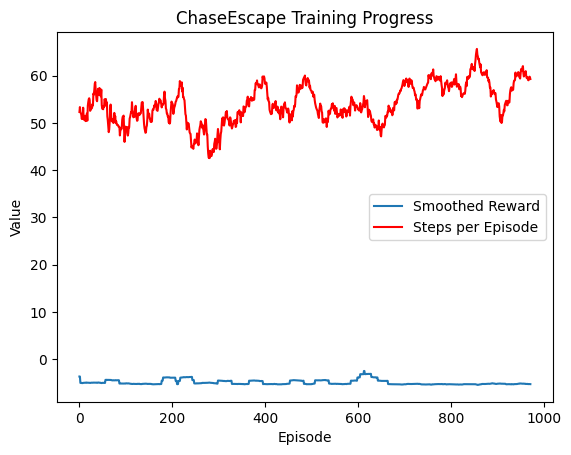

In [23]:
# Smooth data using a moving average with window size 30
window = 30
kernel = np.ones(window) / window

smoothed_rewards = np.convolve(rewards_list, kernel, mode='valid')
smoothed_steps = np.convolve(number_of_moves_list, kernel, mode='valid')

# Plot the results
plt.plot(smoothed_rewards, label='Smoothed Reward')
plt.plot(smoothed_steps, color='red', label='Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.legend()
plt.title('ChaseEscape Training Progress')
plt.show()


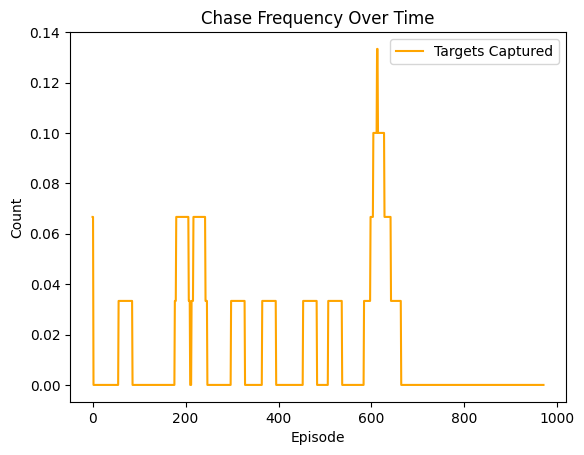

In [25]:
# Apply a moving average filter with window size 30
smoothing_window = 30
avg_filter = np.ones(smoothing_window) / smoothing_window
smoothed_chases = np.convolve(no_of_food_eaten_list, avg_filter, mode='valid')

# Plot the smoothed number of successful target chases
plt.plot(smoothed_chases, color='orange', label='Targets Captured')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Chase Frequency Over Time')
plt.legend()
plt.show()


In [26]:
def evaluate_chase_escape_agent(agent, episodes=10, render=True, max_steps=500):
    env = ChaseEscapeEnv(render_mode="human" if render else None)
    food_capture_counts = []
    step_counts = []
    episode_rewards = []

    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        captures = 0
        total_reward = 0

        while not done and steps < max_steps:
            steps += 1
            # Add small random noise to escape potential local minima
            noisy_obs = obs + np.random.rand(len(obs)) * 0.1
            state_tensor = torch.tensor(noisy_obs, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                q_vals = agent(state_tensor)
                action = torch.argmax(q_vals, dim=1).item()

            obs, reward, done, captured, _, _ = env.step((action % 3, (action // 3) % 3))

            if captured:
                captures += 1

            total_reward += reward

            if render:
                env.render()

        episode_rewards.append(total_reward)
        step_counts.append(steps)
        food_capture_counts.append(captures)

        print(f"Episode {ep + 1}: Steps Taken = {steps}, Targets Collected = {captures}")

    env.close()

    avg_steps = sum(step_counts) / episodes
    avg_captures = sum(food_capture_counts) / episodes

    print(f"Average Steps per Episode: {avg_steps:.2f}")
    print(f"Average Targets Collected per Episode: {avg_captures:.2f}")


In [29]:
evaluate_chase_escape_agent(agent=primary_net, episodes=50, max_steps=1500, render=False)


Episode 1: Steps Taken = 62, Targets Collected = 0
Episode 2: Steps Taken = 63, Targets Collected = 0
Episode 3: Steps Taken = 51, Targets Collected = 0
Episode 4: Steps Taken = 46, Targets Collected = 0
Episode 5: Steps Taken = 61, Targets Collected = 0
Episode 6: Steps Taken = 51, Targets Collected = 0
Episode 7: Steps Taken = 59, Targets Collected = 0
Episode 8: Steps Taken = 64, Targets Collected = 0
Episode 9: Steps Taken = 63, Targets Collected = 0
Episode 10: Steps Taken = 74, Targets Collected = 0
Episode 11: Steps Taken = 77, Targets Collected = 0
Episode 12: Steps Taken = 62, Targets Collected = 0
Episode 13: Steps Taken = 63, Targets Collected = 0
Episode 14: Steps Taken = 57, Targets Collected = 0
Episode 15: Steps Taken = 46, Targets Collected = 0
Episode 16: Steps Taken = 11, Targets Collected = 0
Episode 17: Steps Taken = 48, Targets Collected = 0
Episode 18: Steps Taken = 65, Targets Collected = 0
Episode 19: Steps Taken = 71, Targets Collected = 0
Episode 20: Steps Tak